# 24 · Segmentación por K-means

## 1) Introducción

K-means particiona los datos en \(K\) grupos minimizando la distancia a centroides. En imágenes, cada píxel es un vector de características (color y/o posición).

## 2) Cargar imagen

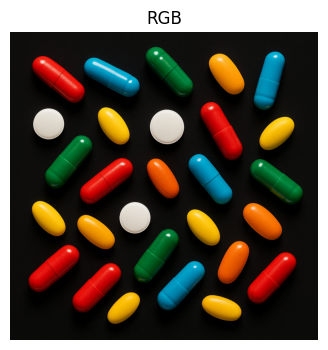

In [11]:
import cv2, numpy as np, matplotlib.pyplot as plt
IMG_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\pildoras2.png"
bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {IMG_PATH}")
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4,4)); plt.imshow(rgb); plt.title('RGB'); plt.axis('off'); plt.show()


## 3) Utilidades

In [12]:
import numpy as np, cv2
def to_colorspace(bgr, mode='RGB'):
    if mode=='RGB': return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    if mode=='HSV': return cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    if mode=='Lab': return cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    raise ValueError('modo inválido')

def from_colorspace_to_rgb(img_cs, mode='RGB'):
    if mode=='RGB': return img_cs.copy()
    if mode=='HSV': return cv2.cvtColor(img_cs, cv2.COLOR_HSV2RGB)
    if mode=='Lab': return cv2.cvtColor(img_cs, cv2.COLOR_LAB2RGB)
    raise ValueError('modo inválido')

def feature_stack(img_cs, spatial_w=0.0):
    H,W = img_cs.shape[:2]
    c = img_cs.reshape(-1,3).astype(np.float32)
    c = c/255.0 if img_cs.dtype==np.uint8 else c
    if spatial_w>0:
        yy,xx = np.mgrid[0:H,0:W]
        xx = (xx.astype(np.float32)/(max(1,W-1)))*spatial_w
        yy = (yy.astype(np.float32)/(max(1,H-1)))*spatial_w
        xy = np.stack([xx,yy],axis=2).reshape(-1,2)
        X = np.hstack([c,xy]).astype(np.float32)
    else:
        X = c.astype(np.float32)
    return X,H,W

def run_kmeans(X, K=3, attempts=3, max_iter=20, init_pp=True):
    criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, int(max_iter), 1.0)
    flags = cv2.KMEANS_PP_CENTERS if init_pp else cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(X, K, None, criteria, attempts, flags)
    return compactness, labels.reshape(-1), centers

def labels_to_image(labels, centers, shape_hw, mode='RGB'):
    H,W = shape_hw
    color_centers = centers[:,:3]
    pal = np.clip(np.rint(color_centers*255.0),0,255).astype(np.uint8)[labels].reshape(H,W,3)
    return from_colorspace_to_rgb(pal, mode)


## 4) Interactivo

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

w_K = widgets.IntSlider(value=4, min=2, max=10, step=1, description='K')
w_space = widgets.Dropdown(options=['RGB','HSV','Lab'], value='Lab', description='ColorSpace')
w_spw = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='peso (x,y)')
w_attempts = widgets.IntSlider(value=3, min=1, max=10, step=1, description='attempts')
w_maxit = widgets.IntSlider(value=20, min=5, max=200, step=5, description='max_iter')
w_initpp = widgets.Checkbox(value=True, description='KMEANS++ init')

display(widgets.HBox([w_K, w_space, w_spw]))
display(widgets.HBox([w_attempts, w_maxit, w_initpp]))
out = widgets.Output(); display(out)

def refresh(*args):
    with out:
        clear_output(wait=True)
        img_cs = to_colorspace(bgr, w_space.value)
        X,H,W = feature_stack(img_cs, spatial_w=w_spw.value)
        comp, labels, centers = run_kmeans(X, K=w_K.value, attempts=w_attempts.value, max_iter=w_maxit.value, init_pp=w_initpp.value)
        seg = labels_to_image(labels, centers, (H,W), mode=w_space.value)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1); plt.imshow(rgb); plt.title('RGB (original)'); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(seg); plt.title(f'K-means {w_space.value} | K={w_K.value} | peso_xy={w_spw.value:.2f}'); plt.axis('off')
        plt.suptitle(f'compactness={comp:.2f} | attempts={w_attempts.value} | init={"++" if w_initpp.value else "random"}', fontsize=10)
        plt.tight_layout(); plt.show()

for w in [w_K, w_space, w_spw, w_attempts, w_maxit, w_initpp]: w.observe(refresh, names='value')
refresh()


Output()

## 5) Notas prácticas

- **Lab** suele ser más perceptual que RGB.
- Añadir coordenadas (x,y) evita clusters cromáticos fragmentados espacialmente.
- No subas demasiado `K`: puede sobresegmentar.
- Usa `KMEANS++` para inicializaciones más estables.
